In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import network, utils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
patches = utils.load_dataset('natural_images/')

### 3.2.2

In [4]:
patch_size = 16
n_out = 20 
n_iter = int(150*1e3)
gamma = 1e-4
dt = 0.1
n_steps = 10
seed = 0

In [5]:
net = network.Visual_network(
    n_out=n_out,
    n_in=patch_size*patch_size,
    transfer_function=network.competitive_transfer_function,
    transfer_function_params={
        'V': network.create_V(n_out, seed=seed),
        'dt': dt,
        'n_steps': n_steps,
        'v_non_linearity': network.competitive_non_linearity_V
    },
    rule_non_linearity=network.competitive_non_linearity_W,
    update_rule=network.competitive_update,
    seed=seed
)
competitive_untrained_weights = net.weights.copy()
competitive_untrained_lateral_weights = net.transfer_function_params['V'].copy()

v_list = []
theta = np.array([1])
phi = np.array([0])
utils.train_network(
        net=net,
        patches=patches,
        theta=theta,
        phi=phi,
        n_iter=n_iter,
        gamma=gamma,
        seed=seed,
        v_list=v_list
    )

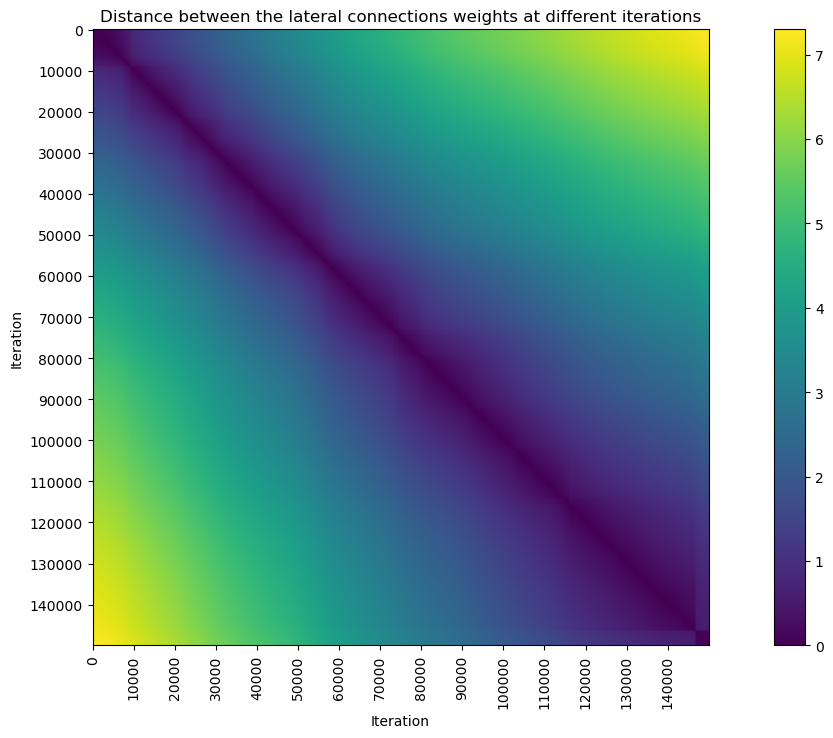

In [6]:
utils.plot_v_list(v_list=v_list, subsampling_factor=100)

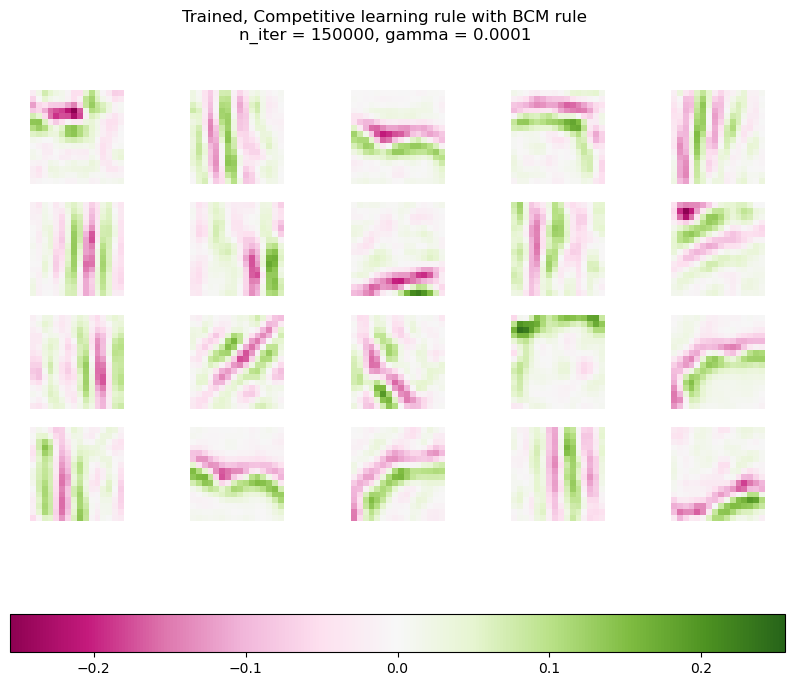

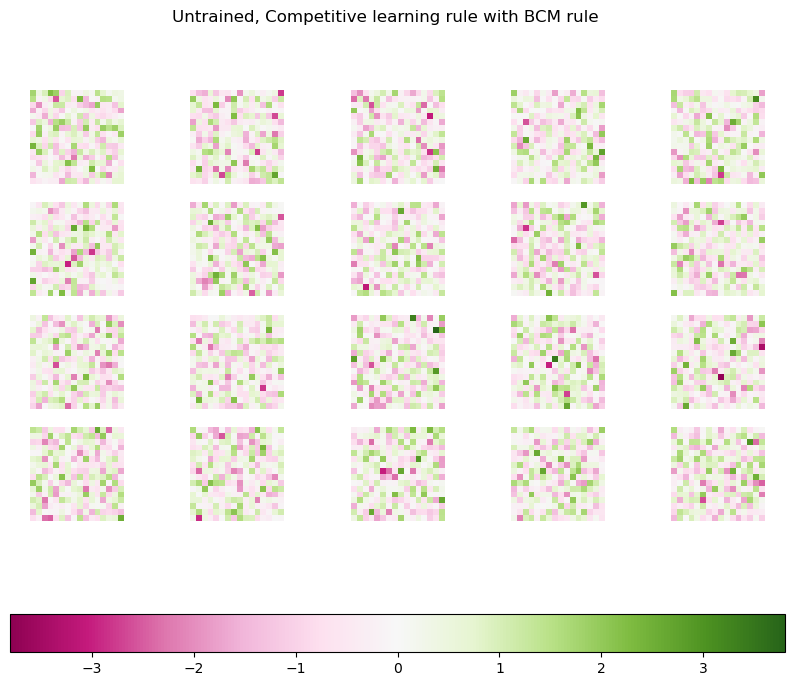

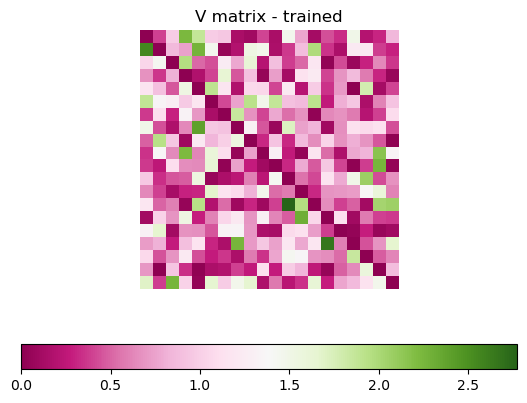

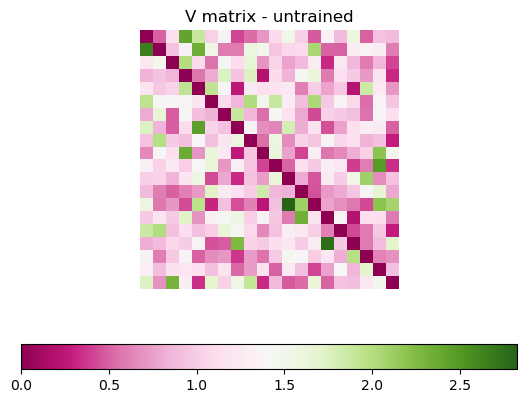

In [7]:
utils.show_RFs(
    Ws = net.weights,
    n_col = 5,
    title = f"Trained, Competitive learning rule with BCM rule\n"
          f"n_iter = {n_iter}, gamma = {gamma}",
    patch_size = patch_size
)

utils.show_RFs(
    Ws = competitive_untrained_weights,
    n_col = 5,
    title = f"Untrained, Competitive learning rule with BCM rule",
    patch_size = patch_size
)

plt.imshow(v_list[0], cmap='PiYG')
plt.title('V matrix - trained')
plt.axis('off')
plt.colorbar(orientation='horizontal')

plt.figure()
plt.imshow(v_list[-1], cmap='PiYG')
plt.title('V matrix - untrained')
plt.axis('off')
plt.colorbar(orientation='horizontal')
plt.show()



#### Answer:
Like in precedent RFs vertical bars are still there, but now we also pick up horizontals, diagonals and a few curved / corner-like shapes. The inhibition term pushes a unit away from any feature that a neighbour already owns: weights that overlap with another unit’s receptive field get suppressed, so each RF is more localized and shows higher contrast than in the non-competing $20$-unit run.
Fixed $\theta$ on its own gave copies of the first principal component, but adding lateral inhibition forces the network to carve up the input space and yields a diverse set of edge detectors: in a way we obtain a similar result to the one with adaptive $\theta$, single neuron, different seeds but here we are visualizing the RFs of all the neurons of the same net at once instead of $20$ times the same neuron with different initializations.


### 3.2.3

In [8]:
non_competitive_net = network.Visual_network(
        n_in=16*16,
        n_out=20,
        seed=seed,
    )
utils.train_network(
    net=non_competitive_net,
    patches=patches,
    theta=np.array([1]),
    n_iter=150000,
    gamma=1e-4,
    seed=seed,
    tau=None
)

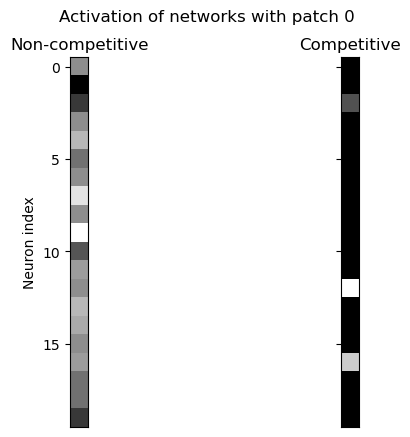

In [9]:
patch_idx = 0
patch = patches[patch_idx]
non_competitive_activation = non_competitive_net.forward(patch)[:, np.newaxis]
competitive_activation = net.forward(patch)[0][:, np.newaxis]

fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].imshow(non_competitive_activation, cmap='gray')
ax[0].set_title('Non-competitive')
ax[0].set_xticks([])
ax[0].set_ylabel('Neuron index')
ax[0].set_yticks(np.arange(0, n_out, 5))

ax[1].imshow(competitive_activation, cmap='gray')
ax[1].set_title('Competitive')
ax[1].set_xticks([])

plt.suptitle(f'Activation of networks with patch {patch_idx}')
plt.show()


#### Answer:
The competitive network has way sparser activations than the non-competitive network and this confirm the diversity of the different units as specialized detectors that represent each a cluster in the kmeans sense of the input space.

### 3.2.4

In [10]:
neuron_idx = 9
spiking_frequencies = []
for patch in patches:
    
    patch_activations = []
    
    net.transfer_function_params['V'] = v_list[-1]
    patch_activations.append(net.forward(patch)[0])
    
    net.transfer_function_params['V'] = v_list[0]
    patch_activations.append(net.forward(patch, weights=competitive_untrained_weights)[0])
    
    spiking_frequencies.append(np.array(patch_activations))
    
net.transfer_function_params['V'] = v_list[-1]
    
spiking_frequencies = np.array(spiking_frequencies)[:, :, neuron_idx]
spiking_difference = spiking_frequencies[:, 0] - spiking_frequencies[:, 1]

(-40.0, 40.0)

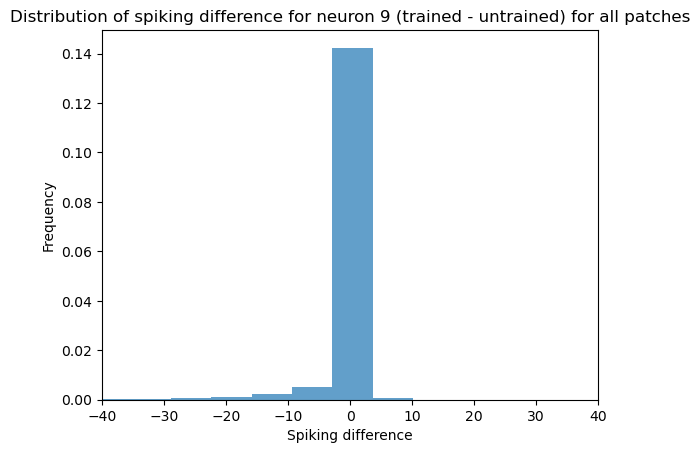

In [11]:
plt.hist(
    spiking_difference,
    bins=30,
    alpha=0.7,
    density=True,
)
plt.title(f'Distribution of spiking difference for neuron {neuron_idx} (trained - untrained) for all patches')
plt.xlabel('Spiking difference')
plt.ylabel('Frequency')
plt.xlim([-40, 40])

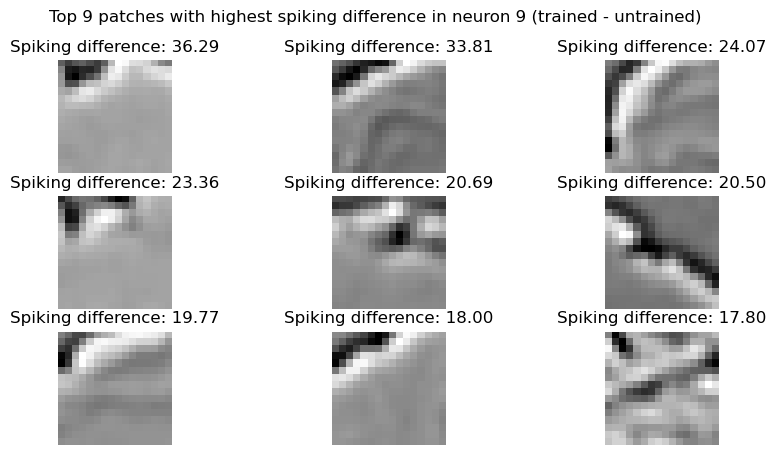

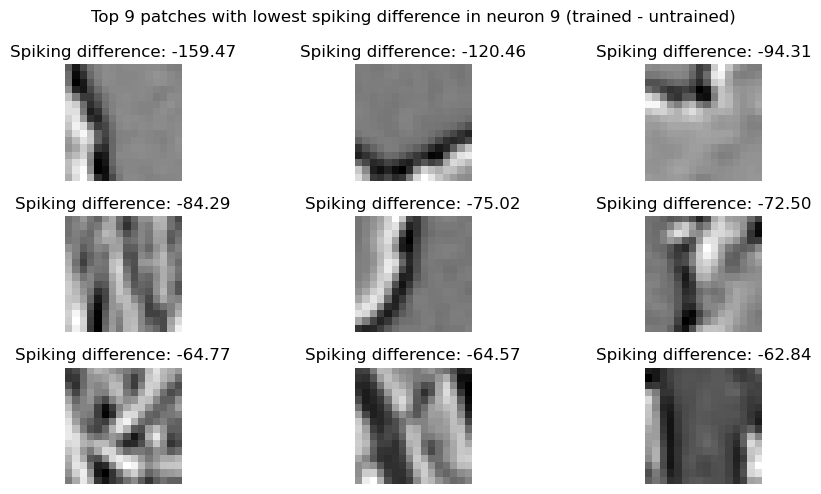

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(10, 5))
spiking_difference_sorted_indices = np.argsort(spiking_difference)[::-1]
for i, ax in enumerate(axs.flat):
    ax.imshow(patches[spiking_difference_sorted_indices[i]].reshape(16, 16), cmap='gray')
    ax.set_title(f'Spiking difference: {spiking_difference[spiking_difference_sorted_indices[i]]:.2f}')
    ax.axis('off')
plt.suptitle(f'Top 9 patches with highest spiking difference in neuron {neuron_idx} (trained - untrained)')

fig, axs = plt.subplots(3, 3, figsize=(10, 5))
spiking_difference_sorted_indices = spiking_difference_sorted_indices[::-1]
for i, ax in enumerate(axs.flat):
    ax.imshow(patches[spiking_difference_sorted_indices[i]].reshape(16, 16), cmap='gray')
    ax.set_title(f'Spiking difference: {spiking_difference[spiking_difference_sorted_indices[i]]:.2f}')
    ax.axis('off')
plt.suptitle(f'Top 9 patches with lowest spiking difference in neuron {neuron_idx} (trained - untrained)')
plt.tight_layout()
plt.show()

### 3.2.5
#### Answer:
It is approximating the running exponential average of the firing rate $y_i$ of each unit $i$.
We update the state variable $\phi_i$ after every pattern presentation $t$
$$
\phi_i^{(t+1)} \;=\; \phi_i^{(t)} \;+\; 
\frac{1}{\tau}\,\Bigl(y_i^{(t)} - \phi_i^{(t)}\Bigr).
\tag{1}
$$


Rewrite (1) as
$$
\phi_i^{(t+1)} 
= \Bigl(1-\tfrac{1}{\tau}\Bigr)\,\phi_i^{(t)}
  + \tfrac{1}{\tau}\,y_i^{(t)} .
\tag{2}
$$

Iterating (2) $k$ steps back gives the closed form  (a geometric series with ratio $1-1/\tau$):
$$
\boxed{\;
\phi_i^{(t+1)} = 
\sum_{k=0}^{t}
\bigl(1-\tfrac{1}{\tau}\bigr)^{k}\,
\frac{1}{\tau}\,y_i^{(t-k)}
\;}
\tag{3}
$$

Hence each past firing $y_i^{(t-k)}$ contributes with weight $\bigl(1-1/\tau\bigr)^{k}$, which decays exponentially with time constant $\tau$.

If $y_i$ is *stationary* (mean $\mu=\mathbb{E}[y_i]$),
taking expectations in (3) gives
$$
\mathbb{E}\bigl[\phi_i^{(t)}\bigr]
  = \mu\sum_{k=0}^{\infty}
    \bigl(1-\tfrac{1}{\tau}\bigr)^{k}\frac{1}{\tau}
  = \mu \;\;\;\text{(since the series sums to }1).
$$



### 3.2.6

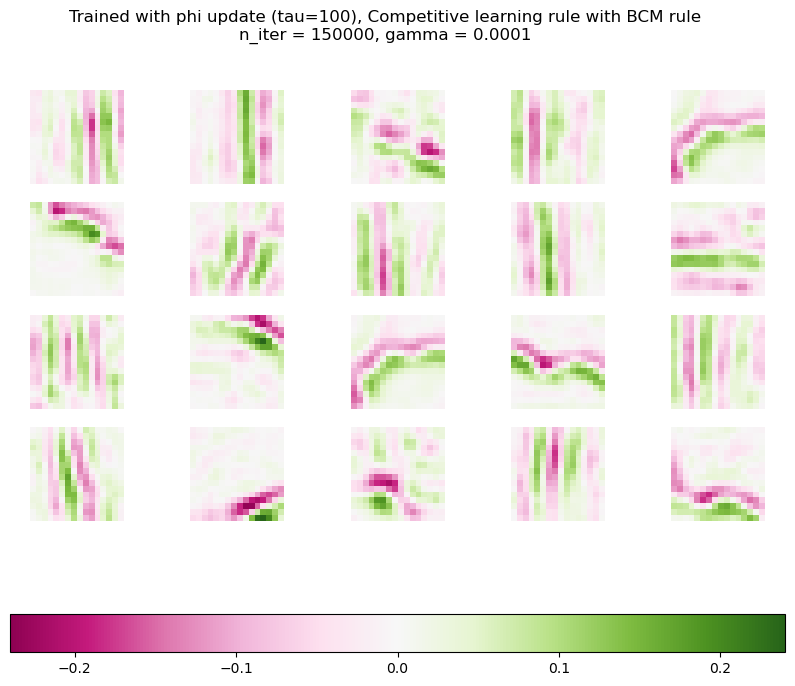

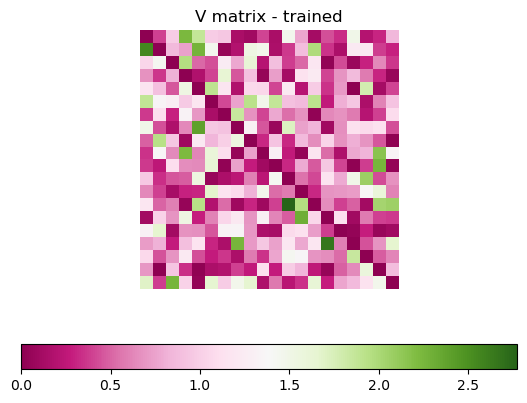

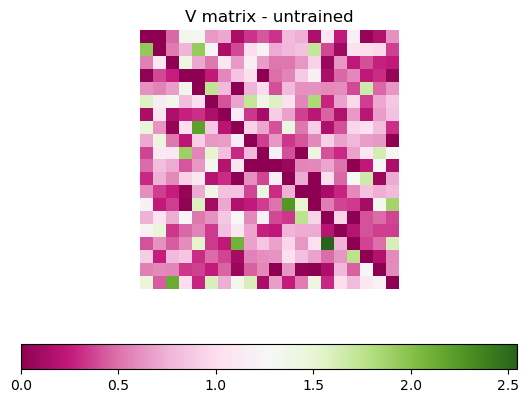

In [17]:
patch_size = 16
n_out = 20 
n_iter = int(150*1e3)
gamma = 1e-4
tau = 100
dt = 0.1
n_steps = 10
seed = 0

net = network.Visual_network(
    n_out=n_out,
    n_in=patch_size*patch_size,
    transfer_function=network.competitive_transfer_function,
    transfer_function_params={
        'V': network.create_V(n_out, seed=seed),
        'dt': dt,
        'n_steps': n_steps,
        'v_non_linearity': network.competitive_non_linearity_V
    },
    rule_non_linearity=network.competitive_non_linearity_W,
    update_rule=network.competitive_update,
    seed=seed
)

v_list = []
theta = np.ones((n_out,))
phi = np.zeros((n_out,))
utils.train_network(
        net=net,
        patches=patches,
        theta=theta,
        phi=phi,
        n_iter=n_iter,
        gamma=gamma,
        seed=seed,
        v_list=v_list,
        tau=tau,
        learn_theta=False,
        learn_phi=True,
    )

utils.show_RFs(
    Ws = net.weights,
    n_col = 5,
    title = f"Trained with phi update (tau={tau}), Competitive learning rule with BCM rule\n"
          f"n_iter = {n_iter}, gamma = {gamma}",
    patch_size = patch_size
)

plt.imshow(v_list[0], cmap='PiYG')
plt.title('V matrix - trained')
plt.axis('off')
plt.colorbar(orientation='horizontal')

plt.figure()
plt.imshow(v_list[-1], cmap='PiYG')
plt.title('V matrix - untrained')
plt.axis('off')
plt.colorbar(orientation='horizontal')
plt.show()

#### Answer:
We don't see much difference in the RFs with respect to the ones of $3.2.2$ : it seems the units capture the same features but in a permuted order.

### 3.2.7

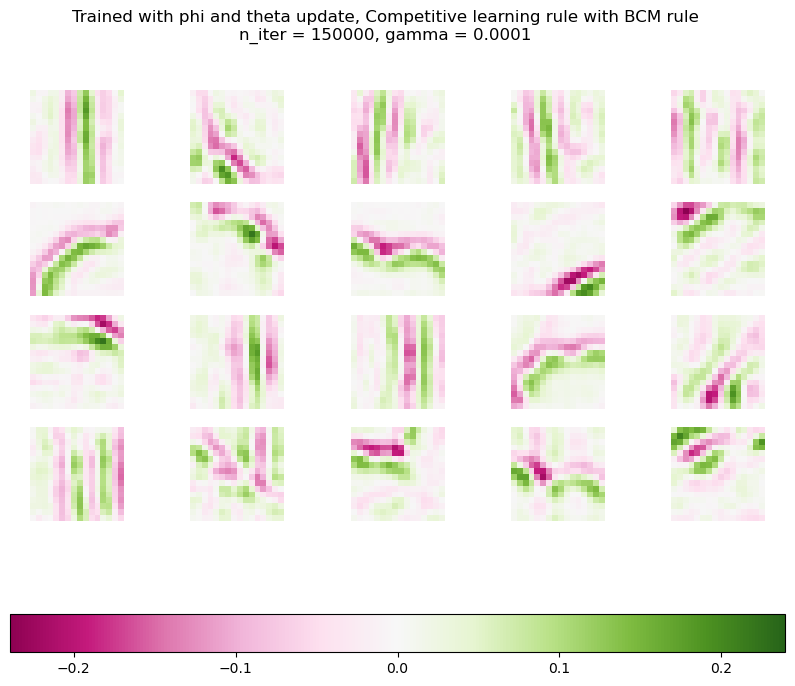

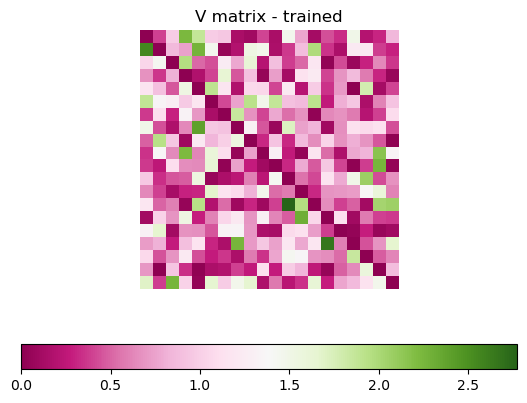

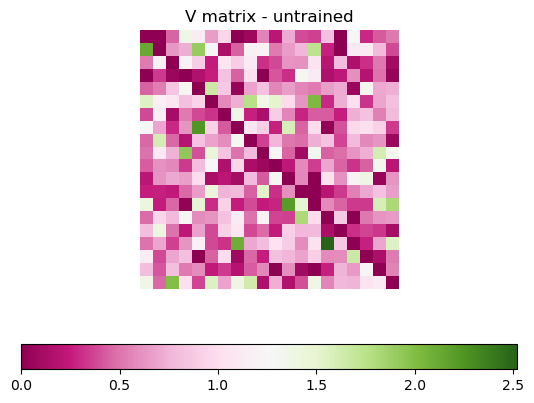

In [18]:
patch_size = 16
n_out = 20 
n_iter = int(150*1e3)
gamma = 1e-4
tau = 100
dt = 0.1
n_steps = 10
seed = 0

net = network.Visual_network(
    n_out=n_out,
    n_in=patch_size*patch_size,
    transfer_function=network.competitive_transfer_function,
    transfer_function_params={
        'V': network.create_V(n_out, seed=seed),
        'dt': dt,
        'n_steps': n_steps,
        'v_non_linearity': network.competitive_non_linearity_V
    },
    rule_non_linearity=network.competitive_non_linearity_W,
    update_rule=network.competitive_update,
    seed=seed
)

v_list = []
theta = np.zeros((n_out,))
phi = np.zeros((n_out,))
utils.train_network(
        net=net,
        patches=patches,
        theta=theta,
        phi=phi,
        n_iter=n_iter,
        gamma=gamma,
        seed=seed,
        v_list=v_list,
        tau=tau,
        learn_theta=True,
        learn_phi=True,
    )

utils.show_RFs(
    Ws = net.weights,
    n_col = 5,
    title = f"Trained with phi and theta update, Competitive learning rule with BCM rule\n"
          f"n_iter = {n_iter}, gamma = {gamma}",
    patch_size = patch_size
)

plt.imshow(v_list[0], cmap='PiYG')
plt.title('V matrix - trained')
plt.axis('off')
plt.colorbar(orientation='horizontal')

plt.figure()
plt.imshow(v_list[-1], cmap='PiYG')
plt.title('V matrix - untrained')
plt.axis('off')
plt.colorbar(orientation='horizontal')
plt.show()

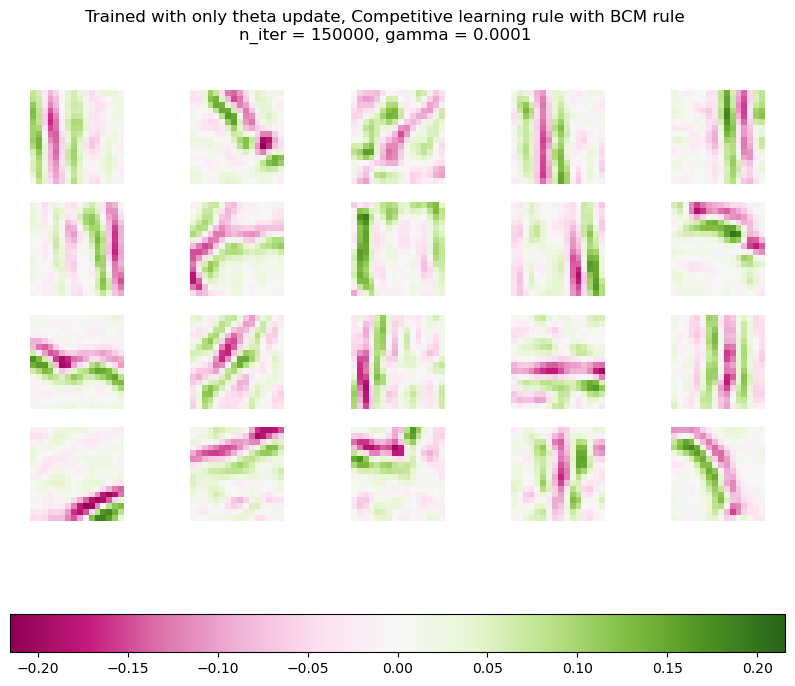

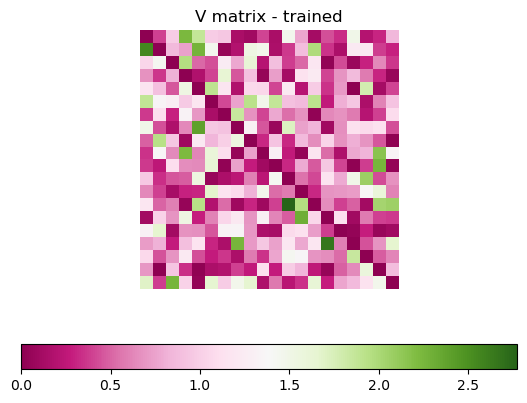

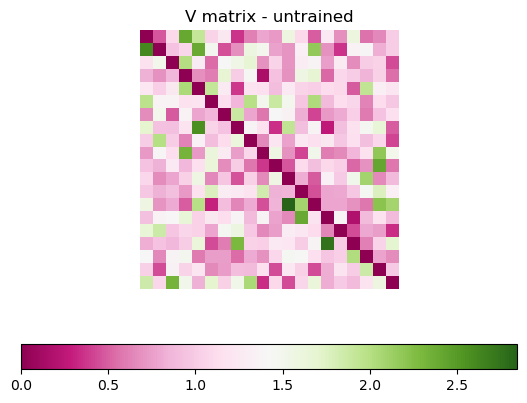

In [19]:
patch_size = 16
n_out = 20 
n_iter = int(150*1e3)
gamma = 1e-4
tau = 10
dt = 0.1
n_steps = 10
seed = 0

net = network.Visual_network(
    n_out=n_out,
    n_in=patch_size*patch_size,
    transfer_function=network.competitive_transfer_function,
    transfer_function_params={
        'V': network.create_V(n_out, seed=seed),
        'dt': dt,
        'n_steps': n_steps,
        'v_non_linearity': network.competitive_non_linearity_V
    },
    rule_non_linearity=network.competitive_non_linearity_W,
    update_rule=network.competitive_update,
    seed=seed
)
competitive_untrained_weights = net.weights.copy()
competitive_untrained_lateral_weights = net.transfer_function_params['V'].copy()

v_list = []
theta = np.zeros((n_out,))
phi = np.zeros((n_out,))
utils.train_network(
        net=net,
        patches=patches,
        theta=theta,
        phi=phi,
        n_iter=n_iter,
        gamma=gamma,
        seed=seed,
        v_list=v_list,
        tau=tau,
        learn_theta=True,
        learn_phi=False,
    )

utils.show_RFs(
    Ws = net.weights,
    n_col = 5,
    title = f"Trained with only theta update, Competitive learning rule with BCM rule\n"
          f"n_iter = {n_iter}, gamma = {gamma}",
    patch_size = patch_size
)

plt.imshow(v_list[0], cmap='PiYG')
plt.title('V matrix - trained')
plt.axis('off')
plt.colorbar(orientation='horizontal')

plt.figure()
plt.imshow(v_list[-1], cmap='PiYG')
plt.title('V matrix - untrained')
plt.axis('off')
plt.colorbar(orientation='horizontal')
plt.show()

#### Answer:
Variable $\theta$ is helpful but not indispensable once we already have strong lateral competition.
In the two grids the set trained with $\theta$ only looks just as diverse as the one trained with both $\phi$ and $\theta$; orientations, positions and curved shapes all appear. This shows that competition by itself can force the units to spread out, so $\theta$ is not strictly required for diversity in that setting. What it does add is stability: it keeps single units from saturating (their contrasts are a little cleaner in the $\phi + \theta$ run) and it still matters in a non-competitive network, where without it every neuron would converge to the same feature.

### 3.2.8

No boundary found for seed 0 and lambda 0.09. Skipping.
No boundary found for seed 0 and lambda 0.05. Skipping.


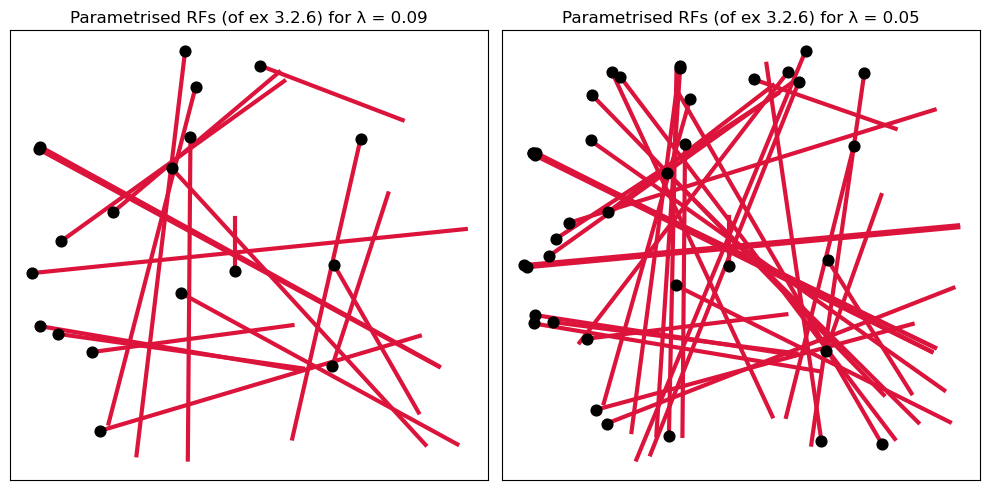

In [16]:
patch_size = 16
n_out = 20 
n_iter = int(150*1e3)
gamma = 1e-4
tau = 10
dt = 0.1
n_steps = 10
seed = 0

net = network.Visual_network(
    n_out=n_out,
    n_in=patch_size*patch_size,
    transfer_function=network.competitive_transfer_function,
    transfer_function_params={
        'V': network.create_V(n_out, seed=seed),
        'dt': dt,
        'n_steps': n_steps,
        'v_non_linearity': network.competitive_non_linearity_V
    },
    rule_non_linearity=network.competitive_non_linearity_W,
    update_rule=network.competitive_update,
    seed=seed
)

v_list = []
theta = np.ones((n_out,))
phi = np.zeros((n_out,))
utils.train_network(
        net=net,
        patches=patches,
        theta=theta,
        phi=phi,
        n_iter=n_iter,
        gamma=gamma,
        seed=seed,
        v_list=v_list,
        tau=tau,
        learn_theta=False,
        learn_phi=True,
    )
lambdas = [0.09, 0.05]
to_draw = []
fig, axs = plt.subplots(1, len(lambdas), figsize=(10, 5))
for i, lambda_ in enumerate(lambdas):
    for RF in net.weights:
        W_lambda = utils.threshold_weights(RF, lambda_)
        W_boundary, coordinates = utils.find_boundary(W_lambda)
        if len(coordinates) == 0:
            print(f"No boundary found for seed {seed} and lambda {lambda_}. Skipping.")
            continue
        alpha, beta = utils.linear_regression(coordinates)
        params = utils.find_parameters(coordinates, alpha, beta)
        to_draw.append(params)
    for params in to_draw:
        utils.draw_segment(params, 16, ax=axs[i], title =f'Parametrised RFs (of ex 3.2.6) for λ = {lambda_:.2f}')
plt.tight_layout()
plt.show()

### 3.2.9
#### Answer:



With a sliding $\theta$ alone each neuron adjusts its own gain, so it eventually settles on a feature that suits its initial weights and the stimulus statistics. Because different seeds start in different directions the population shows some diversity, but overlap is common and several RFs can still end up coding very similar edges.

Adding lateral inhibition changes the picture. While $\theta$ still keeps individual firing rates in check, the cross-inhibition pushes neurons away from any feature that is already represented by their neighbours. Duplicate RFs are actively suppressed, and the set of receptive fields spreads out until the ensemble tiles the stimulus space with minimal redundancy. Convergence tends to take longer (the weights of one unit keep readjusting whenever its neighbours move) but the final map is far more decorrelated.

From a developmental standpoint the competitive scheme is advantageous: it maximises coverage of orientations, positions and spatial frequencies while using the same total number of cells. The drawback is that strong competition can silence units entirely or drive them to very weak, noisy RFs if parameters are not tuned, whereas the non-competitive network is more robust but wastes capacity on duplicate coding.